# Proof of concept: try fine-tuning MNIST classifier by freezing feature extractor and creating new classes I M P C, 1 2 3 4 and upper lower

1. get data: 5 samples of all teeth. 11 classes -> 60 images.
2. finetune
3. evaluate

## Load the keras model. Try reading one sample

In [16]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2024-09-24 13:04:44.676963: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-24 13:04:44.683188: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-24 13:04:44.702619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 13:04:44.733700: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 13:04:44.742243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 13:04:44.764124: I tensorflow/core/platform/cpu_feature_gu

2.17.0


### Test inference with MNIST

In [17]:
mnist_model = tf.keras.models.load_model('/home/riikoro/thesis/code/pretrained_base_models/bangla_english_handwritten_mnist.keras')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Restored model, accuracy: 100.00%


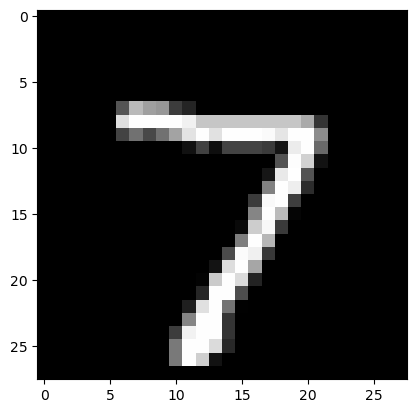

In [32]:
import numpy as np

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

test_labels = test_labels[:100]
test_images = test_images[:100]#.reshape(-1, 28 * 28) / 255.0

test_images = test_images.reshape((100, 28,28,1))
predictions = np.argmax(mnist_model.predict(test_images), axis = 1)

plt.imshow(test_images[0], cmap='gray')

accuracy = np.sum(predictions == test_labels) / len(test_labels)
print('Restored model, accuracy: {:5.2f}%'.format(100 * accuracy))

### Test inference with tooth data

extract 10 numbers for testing

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
correctly classified 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
correctly classified 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
correctly classified 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
correctly classified 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
correctly classified 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
correctly classified 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
correctly classified 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
correctly classified 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
correctly classified 4
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
correctly classified 1
Accuracy: 1.0 %


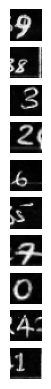

In [36]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

images = glob.glob("digits/*.png")
correct = 0
fig, ax = plt.subplots(10)
for i, filename in enumerate(images):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    reshaped = cv2.resize(image, (28,28))
    label = int(filename[7])
    reshaped = 255 - reshaped # flip color
    ax[i].imshow(reshaped, cmap='gray')
    ax[i].axis('off')
    pred = np.argmax(mnist_model.predict(reshaped.reshape(1,28,28,1)), axis = 1)
    if label == pred:
        print(f'correctly classified {label}')
        correct += 1

print(f"Accuracy: {correct/10} %")

Lessons: 

- flipping color to black background improved accuracy 0.1-> 0.7
- cropping traces from adjacent characters from falsely classified images corrected all classification errors.

### Train model on new data: freeze all but last layer and use dental elements to fine tune

Skip over/underline for now, teach only upper lower script

In [40]:
# freeze layers
for layer in mnist_model.layers[:-1]:
    layer.trainable = False

for layer in mnist_model.layers:
    print(layer.trainable)

False
False
False
False
False
False
False
False
False
False
False
False
True


In [42]:
images = glob.glob("teeth/*.png")

i = 0
for i, filename in enumerate(images):
    image = cv2.imread(filename)
    cv2.imwrite(f'{i}.png', image)

Next: finish labeling
one concern: labeling allows eg third canine. and third and second molar, in a way. should we just have upper/lower and then each tooth? try later. also multivariate -> just the variables next to each other or how?